## Uber demand forecasting for New York City
This is a short example to demonstrate the different and subsequent steps of a machine learning project.<br>
The goal of the project is to predict the demand of uber services in advance. 

### Setup

Import necessary libraries.

In [1]:
import os
import numpy as np
import pandas as pd

import json
from area import area
from matplotlib import path

%matplotlib inline
from matplotlib import pyplot as plt

Set the number of CPUs to be used.

In [2]:
# value 1 -> use 1 CPU
# value 2 -> use 2 CPUs ...
# value -1 -> use all CPUs
# value -2 -> use all but one CPU ...
n_cpus = -2

### Get the data
Get the data for the Uber pickups for NYC for the time period April to September 2014 from the following sources:
```txt
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-may14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jun14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jul14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-aug14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-sep14.csv

```

In [3]:
import urllib

# source from where to download the data
SOURCE_ROOT = 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/'

# dictionary of the files to be downloaded
month_url = {'april_data' :'uber-raw-data-apr14.csv', 'may_data' :'uber-raw-data-may14.csv',
            'june_data' :'uber-raw-data-jun14.csv', 'july_data' :'uber-raw-data-jul14.csv',
            'august_data' :'uber-raw-data-aug14.csv', 'september_data' :'uber-raw-data-sep14.csv'}

# path to store the downloaded data
SAVING_PATH = os.path.join('datasets')

# function to fetch the data
def download_and_save_data(data_source_url = SOURCE_ROOT, data_path = SAVING_PATH):
    # make data directory if not existing
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    
        # get data csv for each month
        for month in month_url:
            data_url = ''
            file_name = month_url[month]

            # status print
            print('download and save {}'.format(file_name))

            # setup the data url
            data_url = data_source_url + file_name

            # specify the douwnload file
            csv_path = os.path.join(data_path, file_name)

            # receive the data from the web
            urllib.request.urlretrieve(data_url, csv_path)

# call the function to download and save the data
download_and_save_data()

Convert the `CSV` files into a pandas `DataFrame` files and store them in a dictionary.

In [4]:
def load_csv_data(csv_path):
    return pd.read_csv(csv_path)

In [5]:
data_dict = {}

for month in month_url:
    csv_filename = month_url[month]
    csv_path = os.path.join(SAVING_PATH, csv_filename)
    pd_filename = month
    data_dict.update({pd_filename : load_csv_data(csv_path)})

In [6]:
data_dict.keys()

dict_keys(['april_data', 'may_data', 'june_data', 'july_data', 'august_data', 'september_data'])

### Gain insights into the data

In [7]:
x = data_dict['april_data']

Print the first ten data rows.

In [8]:
x.head(10)

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
5,4/1/2014 0:33:00,40.7383,-74.0403,B02512
6,4/1/2014 0:39:00,40.7223,-73.9887,B02512
7,4/1/2014 0:45:00,40.7620,-73.9790,B02512
8,4/1/2014 0:55:00,40.7524,-73.9960,B02512
9,4/1/2014 1:01:00,40.7575,-73.9846,B02512


The data consists of four columns with five parameters:

`Data`: The date of the Uber pickup.
<br>
`Time`: The time of the Uber pickup.
<br>
`Lat`: The latitude of the Uber pickup.
<br>
`Lon`: The longitude of the Uber pickup.
<br>
`Base`: The TLC base company code affiliated with the Uber pickup.

Check the amount and completeness of the data point.

In [9]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564516 entries, 0 to 564515
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date/Time  564516 non-null  object 
 1   Lat        564516 non-null  float64
 2   Lon        564516 non-null  float64
 3   Base       564516 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.2+ MB


There are 564516 entries with no missing data point.

`Lon` ans `Lat` are of *float64* data type. These values can be used after scaling them (see later) without further preprocessing. 

`Date/Time` is of type *object* and therefore needs to be converted into a time series format.

`Base` is also of type *object*. We will use one-hot-encoding here.

Lets have a closer look at the `Base` parameter.

In [10]:
x['Base'].value_counts()

B02682    227808
B02598    183263
B02617    108001
B02512     35536
B02764      9908
Name: Base, dtype: int64

The `Base` parameter has five different values.

### Prepare the data

Add a new parameter `pickups` to count the number of pickups. **This will be the label!**

In [11]:
x['Pickups'] = 1

In [12]:
x.head()

,Date/Time,Lat,Lon,Base,Pickups
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,1
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,1
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,1
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,1
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,1


Extract the `Date/Time` parameter column to convert it into a **time series format**.

In [13]:
x_date = x['Date/Time']

In [14]:
x_date.head()

0    4/1/2014 0:11:00
1    4/1/2014 0:17:00
2    4/1/2014 0:21:00
3    4/1/2014 0:28:00
4    4/1/2014 0:33:00
Name: Date/Time, dtype: object

In [15]:
x_date = pd.to_datetime(x_date)

In [16]:
x_date

0        2014-04-01 00:11:00
1        2014-04-01 00:17:00
2        2014-04-01 00:21:00
3        2014-04-01 00:28:00
4        2014-04-01 00:33:00
                 ...        
564511   2014-04-30 23:22:00
564512   2014-04-30 23:26:00
564513   2014-04-30 23:31:00
564514   2014-04-30 23:32:00
564515   2014-04-30 23:48:00
Name: Date/Time, Length: 564516, dtype: datetime64[ns]

Convert x_date back to pandas DataFrame type.

In [17]:
x_data = x_date.to_frame()

In [18]:
x_data

,Date/Time
0,2014-04-01 00:11:00
1,2014-04-01 00:17:00
2,2014-04-01 00:21:00
3,2014-04-01 00:28:00
4,2014-04-01 00:33:00
...,...
564511,2014-04-30 23:22:00
564512,2014-04-30 23:26:00
564513,2014-04-30 23:31:00
564514,2014-04-30 23:32:00


In [19]:
x

,Date/Time,Lat,Lon,Base,Pickups
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,1
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,1
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,1
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,1
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,1
...,...,...,...,...,...
564511,4/30/2014 23:22:00,40.7640,-73.9744,B02764,1
564512,4/30/2014 23:26:00,40.7629,-73.9672,B02764,1
564513,4/30/2014 23:31:00,40.7443,-73.9889,B02764,1
564514,4/30/2014 23:32:00,40.6756,-73.9405,B02764,1


Replace the original `Date/Time` column by the altered time series `Date/Time` column.

In [20]:
x['Date/Time'] = x_data['Date/Time']

In [21]:
x.head()

,Date/Time,Lat,Lon,Base,Pickups
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,1
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,1
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,1
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,1
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,1


Add an additional column for a new parameter called *neighborhood*. This column stores the neighborhoods of NYC generated out of the latitude and longitude values.

In [22]:
x_add = x.copy()

In [23]:
x_add['Neighborhood'] = np.zeros(len(x_add))

In [24]:
x_add

,Date/Time,Lat,Lon,Base,Pickups,Neighborhood
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,1,0.0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,1,0.0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,1,0.0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,1,0.0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,1,0.0
...,...,...,...,...,...,...
564511,2014-04-30 23:22:00,40.7640,-73.9744,B02764,1,0.0
564512,2014-04-30 23:26:00,40.7629,-73.9672,B02764,1,0.0
564513,2014-04-30 23:31:00,40.7443,-73.9889,B02764,1,0.0
564514,2014-04-30 23:32:00,40.6756,-73.9405,B02764,1,0.0


Load a JSON file with the *latitude / longitude* to neighborhood correlation.

In [25]:
# geofile = json.load(open("datasets/Neighborhood_Tabulation_Areas.geojson"))
geofile = json.load(open("datasets/NY_neighborhoods.geojson"))

In [26]:
geo_points = list(zip(x_add['Lon'], x_add['Lat']))

In [27]:
for feature in geofile['features']:
    coords = feature['geometry']['coordinates'][0]
    p = path.Path(coords)
    inds = p.contains_points(geo_points)
    list_neighborhoods = [str(feature['properties']['neighborhood'])]*np.sum(inds)
    x_add.loc[x_add.index[inds], 'Neighborhood'] = list_neighborhoods

In [28]:
x_add

,Date/Time,Lat,Lon,Base,Pickups,Neighborhood
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,1,Upper East Side
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,1,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,1,East Village
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,1,Midtown
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,1,Midtown
...,...,...,...,...,...,...
564511,2014-04-30 23:22:00,40.7640,-73.9744,B02764,1,Midtown
564512,2014-04-30 23:26:00,40.7629,-73.9672,B02764,1,Upper East Side
564513,2014-04-30 23:31:00,40.7443,-73.9889,B02764,1,Midtown
564514,2014-04-30 23:32:00,40.6756,-73.9405,B02764,1,Crown Heights


Remove all non-matching entries. These were entries with pickups outside of central NYC.

In [29]:
x_add = x_add[x_add['Neighborhood'] != 0]

In [30]:
x_add

,Date/Time,Lat,Lon,Base,Pickups,Neighborhood
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,1,Upper East Side
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,1,East Village
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,1,Midtown
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,1,Midtown
6,2014-04-01 00:39:00,40.7223,-73.9887,B02512,1,Lower East Side
...,...,...,...,...,...,...
564511,2014-04-30 23:22:00,40.7640,-73.9744,B02764,1,Midtown
564512,2014-04-30 23:26:00,40.7629,-73.9672,B02764,1,Upper East Side
564513,2014-04-30 23:31:00,40.7443,-73.9889,B02764,1,Midtown
564514,2014-04-30 23:32:00,40.6756,-73.9405,B02764,1,Crown Heights


In [31]:
x_add['Neighborhood'].value_counts()

Midtown            91453
Upper East Side    47900
Chelsea            46122
West Village       29000
SoHo               26174
                   ...  
Broad Channel          1
Neponsit               1
Arverne                1
Todt Hill              1
Huguenot               1
Name: Neighborhood, Length: 234, dtype: int64

There are 234 listed neighborhood. One should check if these neighborhood are correct. But I will not do it for now.

In [32]:
len_x_add = len(x_add.index)
print(len_x_add)

551251


Cluster the data within time intervals of one hour.

In [33]:
x_cluster = x.resample('H', on='Date/Time').agg({'Pickups' : 'sum', 'Base': 'nunique', 'Lat': 'nunique', 'Lon': 'nunique'})

In [34]:
x_cluster

,Pickups,Base,Lat,Lon
Date/Time,,,,
2014-04-01 00:00:00,138,5,118,125
2014-04-01 01:00:00,66,5,58,62
2014-04-01 02:00:00,53,5,47,49
2014-04-01 03:00:00,93,5,89,85
2014-04-01 04:00:00,166,5,148,148
...,...,...,...,...
2014-04-30 19:00:00,2834,5,861,741
2014-04-30 20:00:00,2766,5,844,723
2014-04-30 21:00:00,2308,5,784,665


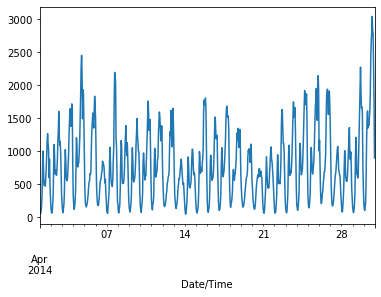

In [35]:
x_cluster['Pickups'].plot();

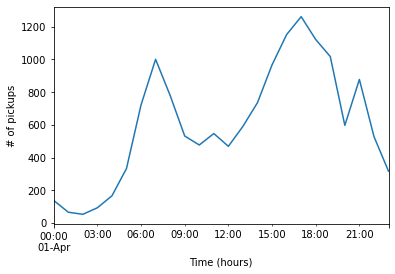

In [36]:
ax = x_cluster.loc['2014-04-01', 'Pickups'].plot()
ax.set_ylabel('# of pickups')
ax.set_xlabel('Time (hours)');

In [37]:
x_cluster.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2014-04-01 00:00:00 to 2014-04-30 23:00:00
Freq: H
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Pickups  720 non-null    int64
 1   Base     720 non-null    int64
 2   Lat      720 non-null    int64
 3   Lon      720 non-null    int64
dtypes: int64(4)
memory usage: 48.1 KB


In [38]:
x_cluster.describe()

,Pickups,Base,Lat,Lon
count,720.000000,720.000000,720.000000,720.000000
mean,784.050000,4.979167,461.730556,422.827778
std,538.648605,0.142925,214.670261,183.811094
min,45.000000,4.000000,42.000000,44.000000
25%,353.750000,5.000000,293.750000,281.000000
50%,682.500000,5.000000,484.000000,451.500000
75%,1076.500000,5.000000,630.000000,568.000000
max,3038.000000,5.000000,906.000000,776.000000
